In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import bambi as bmb
import arviz as az
from sklearn.preprocessing import StandardScaler

Problemen:
- Geen volledige paden in repo (veiligheidsrisicio)
- Encoding dataset naar UTF8 omzetten (encoding problemen?)

In [3]:
df = pd.read_csv("../Materials/KVO_META.csv", encoding='utf8')
df['Datum'] = pd.to_datetime(df['Datum'], dayfirst=True, errors='coerce')
df.sample(5)

,Column1,Afbeelding,Collectie,Productie,Datum,Gelegenheid,Multiple bill,Performances_ID,Genormaliseerde titel,Oorspronkelijke taal,Componist,Oorspronkelijke premi�re,Oorspronkelijke titel,genre,Directie
1835,NaN,1913-1914 Vlaamse Opera_00071-20211216_165513.jpg,1913-1914,Peterke en Meterke,1913-12-07,NaN,True,708880,Peterke en Meterke,NaN,NaN,NaN,NaN,NaN,Henry Fontaine
2815,NaN,1925-1926_00111-20220208_093638.jpg,1925-1926,Taifun,1925-11-19,NaN,False,406454,Taifun,DUI,Tivadar Sz�nti�,?,Taifun,?,F� Derickx & Bernard Tokkie
3655,NaN,1929-1930_00499-20220209_130828.jpg,1929-1930,Faust,1930-02-27,NaN,False,338467,Faust,FR,Charles Gounod,1859,Faust,grand opera,F� Derickx & Bernard Tokkie
3230,NaN,1927-1928_00315-20220208_133642.jpg,1927-1928,Driemeisjeshuis,1927-12-17,NaN,False,581031,Driemeisjeshuis,DUI,Heinrich Bert�,1916,Das Dreim�derlhaus,leichte oper,F� Derickx & Bernard Tokkie
1028,NaN,1907-1908 Vlaamsche opera_00040-20211216_13283...,1907-1908,Het Arendsnest,1907-10-19,Gala-vertoning,True,236792,Het Arendsnest,NaN,NaN,NaN,NaN,NaN,Jef Judels & Bernard Tokkie


In [4]:
data = []

for work, group in df.groupby('Genormaliseerde titel'):
    group = group.groupby('Collectie').sample(1) # consider one performance per season?
    group = group.sort_values('Datum').iloc[0:2] # get very first performace and first reperformance
    if len(group) > 1:
        time_diff = group.iloc[1]['Datum'].year - group.iloc[0]['Datum'].year
        meta = list(group.iloc[0][['Genormaliseerde titel', 'Directie', 'Componist', 'Oorspronkelijke taal', 'genre', 'Datum']].values)
        data.append(meta + [time_diff])

data = pd.DataFrame(data, columns=['titel', 'directie', 'componist', 'taal', 'genre', 'datum', 'diff'])
data = data[~data['diff'].isna()]
data

,titel,directie,componist,taal,genre,datum,diff
0,Carmen,F� Derickx & Bernard Tokkie,NaN,NaN,NaN,1930-04-29,3
1,Carmen,F� Derickx & Bernard Tokkie,NaN,NaN,NaN,1928-04-29,4
2,Christ'l,Henry Fontaine,NaN,NaN,NaN,1911-02-26,0
3,Czaar en Timmerman,Jef Judels & Bernard Tokkie,NaN,NaN,NaN,1904-03-26,4
4,Dansenreeks,F� Derickx & Bernard Tokkie,NaN,NaN,NaN,1924-01-12,1
...,...,...,...,...,...,...,...
147,Tristan en Isolde,Henry Fontaine,Richard Wagner,DUI,gesamtkunstwerk,1910-12-20,14
148,Weenerbloed,F� Derickx & Bernard Tokkie,Johann Strauss,DUI,operette,1930-01-19,1
149,Winternachtsdroom,Jef Judels & Bernard Tokkie,August de Boeck,NL,lyrisch drama,1904-02-04,2
150,Winternachtsdroom,Jef Judels & Bernard Tokkie,NaN,NaN,NaN,1902-12-20,5


In [5]:
data.dtypes

titel                object
directie             object
componist            object
taal                 object
genre                object
datum        datetime64[ns]
diff                  int64
dtype: object

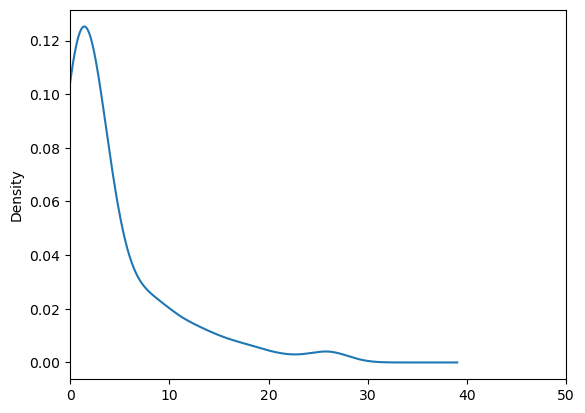

In [6]:
data['diff'].plot.kde()
plt.xlim((0, 50));

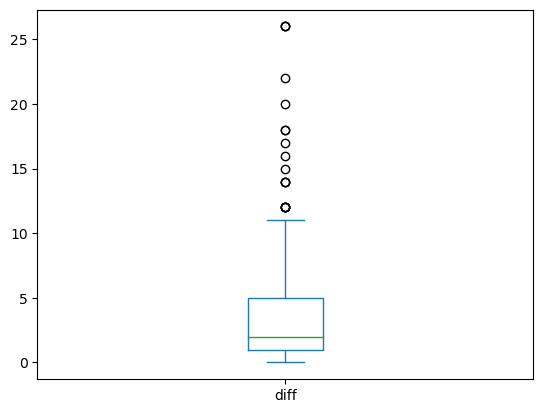

In [7]:
data['diff'].plot.box();

In [8]:
data['diff'].describe()

count    152.000000
mean       4.243421
std        5.567166
min        0.000000
25%        1.000000
50%        2.000000
75%        5.000000
max       26.000000
Name: diff, dtype: float64

In [9]:
import numpy as np
data['diff'] = data['diff'].astype(np.int32)

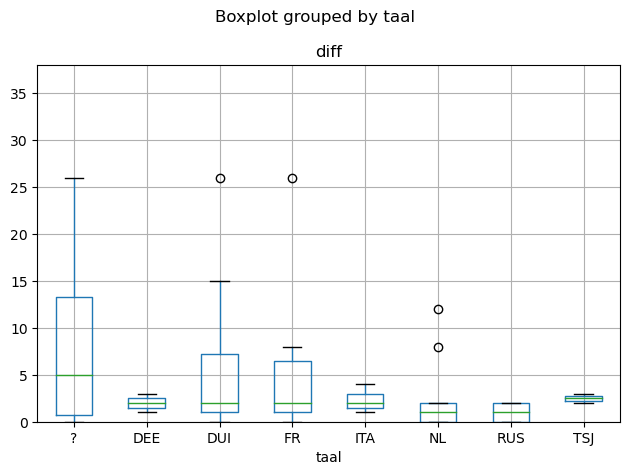

In [10]:
data.boxplot('diff', 'taal')
plt.ylim(0, 38)
plt.tight_layout();

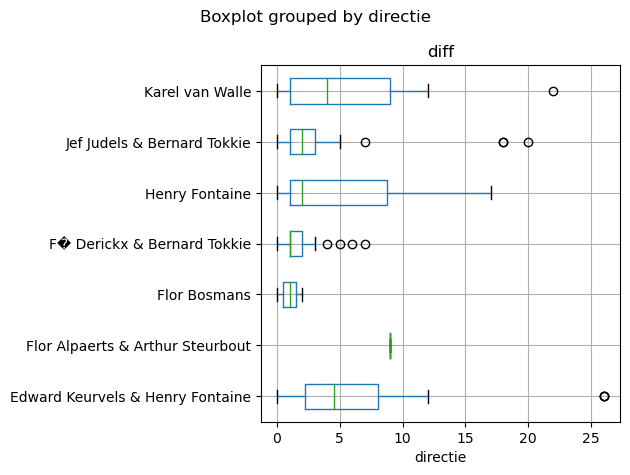

In [11]:
data.boxplot('diff', 'directie', vert=False)
plt.tight_layout();

In [12]:
print(len(data))
data = data[~data.isna()]
print(len(data))

152
152


In [13]:
data = data[['taal', 'diff', 'directie']]
data['taal'].fillna('<UNK>', inplace=True)
data['taal'] = data['taal'].str.replace('?', '<UNK>', regex=False)
data.sample(10)

,taal,diff,directie
72,DUI,1,Henry Fontaine
49,NL,8,Edward Keurvels & Henry Fontaine
77,DUI,0,F� Derickx & Bernard Tokkie
47,FR,1,Henry Fontaine
83,DUI,3,Jef Judels & Bernard Tokkie
22,<UNK>,1,F� Derickx & Bernard Tokkie
21,<UNK>,20,Jef Judels & Bernard Tokkie
112,<UNK>,14,Henry Fontaine
56,DUI,12,Karel van Walle
67,RUS,2,F� Derickx & Bernard Tokkie


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, taal, directie]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


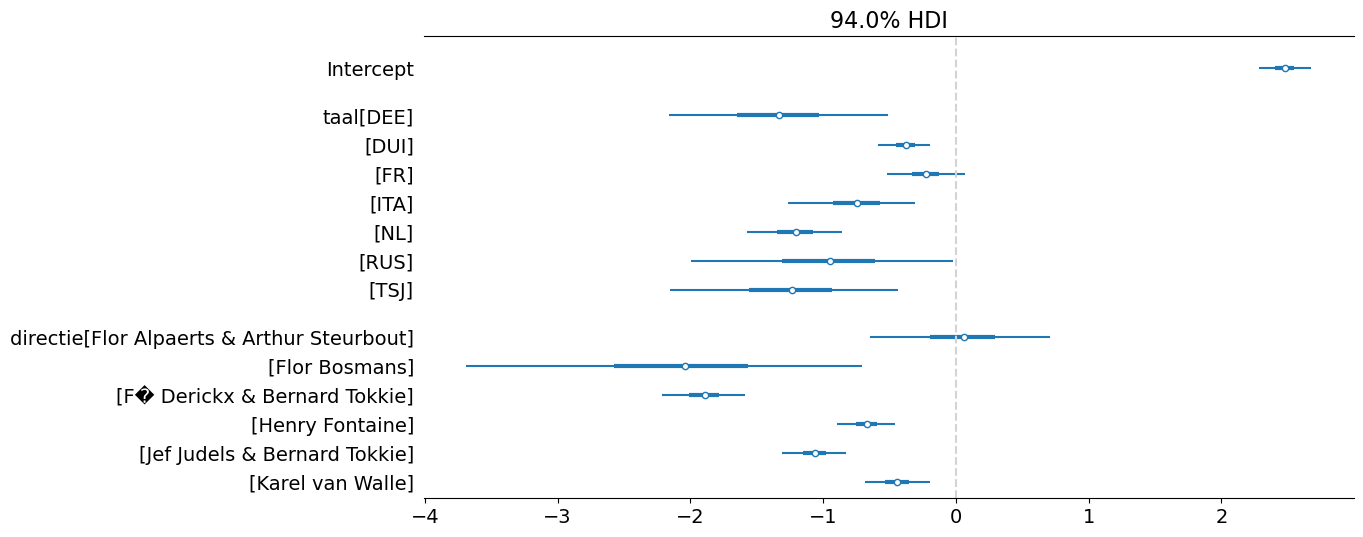

In [14]:
model = bmb.Model('diff ~ taal + directie', data, family='poisson')
fit = model.fit(draws=1000, chains=4)
az.summary(fit)
az.plot_forest(fit, combined=True, figsize=(12, 6))
plt.axvline(0, c='lightgrey', ls='--');